## Initialisation

### Dependencies

#### Third party

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from decimal import Decimal

#### Personal notebook

/home/poski/Desktop/btp/engineering_strain_stress.ipynb:99: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  {
/home/poski/Desktop/btp/engineering_strain_stress.ipynb:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "cell_type": "markdown",


Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 0.01
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 220
Young's Modulus: 27.261192071475786 GPa
Yield Strength: 238.97398200000003 MPa
Ultimate Tensile Strength is 362.20079200000004 MPa at 18.095% elongation.


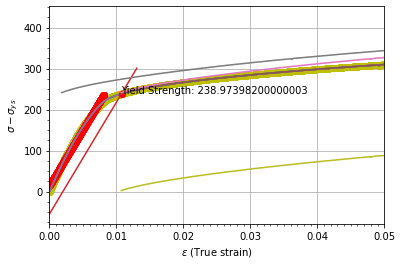

In [2]:
import ipynb

from ipynb.fs.full.dataset_initialisation import (
    OUTPUT_DIR,
)
from ipynb.fs.defs.utilities import (
    differentiate,
    save_parameter,
    save_fig,
)
from ipynb.fs.full.true_strain_stress import (
    true_plastic_strain,
    true_strain,
    flow_stress,
)
from ipynb.fs.full.engineering_strain_stress import (
    yield_strength,
)

### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress
- $\sigma_{s} \rightarrow$ Saturation stress
- $\theta \rightarrow$ Work hardening rate
- $\theta_{0} \rightarrow$ Initial work hardening rate
- $\sigma_{v} \rightarrow$ Scaling stress

## Voce equation

$$ \sigma = \sigma_{s} \left(1 - exp\left(\frac{\theta_{0}}{\sigma_{v}}\right) \epsilon_{pl} \right)  $$

$$ \sigma = \sigma_{s} \left(1 - exp\left(\frac{k_{2}}{2}\right) \epsilon_{pl} \right) \because \frac{\theta_{0}}{\sigma_{v}} = \frac{k_{2}}{2}$$

$ \therefore $ Therefore only two fitting parameters ($ k_{2} $ and $ \sigma_{s} $) are necessary to describe the work hardening behaviour at a given temperature.

$ A $ is $ \sigma_{s} $
$ \\ $
$ B $ is $ \frac{\theta_{0}}{\sigma_{v}} $

For our experiment, we are assuming that scaling stress = saturation stress.

Saturation stress: 206.170300253405 MPa
B: 14.377584601318516
k2: 28.75516920263703


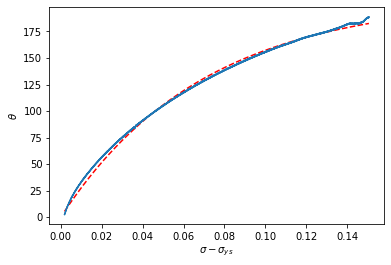

In [18]:
def fit_voce(x, A, B): # A is saturation stress (sigma_s)
    return A*(1-np.exp(-B*x))

rhs_theoretical_voce = curve_fit(
    fit_voce, true_plastic_strain, flow_stress, [100, 5], method='lm'
)

popt, _ = rhs_theoretical_voce
sigma_s = popt[0]
B = popt[1]
_ = plt.plot(true_plastic_strain, [fit_voce(pl,sigma_s,B) for pl in true_plastic_strain], 'r--')
_ = plt.plot(true_plastic_strain, flow_stress)
_ = plt.xlabel('$\sigma - \sigma_{ys}$')
_ = plt.ylabel('$\\theta$')

print(f'Saturation stress: {sigma_s} MPa')
print(f'B: {B}')
print(f'k2: {2*B}')

save_parameter('Saturation stress', sigma_s, 'MPa', f'{OUTPUT_DIR}/output.txt')
save_parameter('k2', 2*B, '', f'{OUTPUT_DIR}/output.txt')

## Initial work hardening rate

$ A $ is $ \sigma_{s} $
$ \\ $
$ B $ is $ \frac{\theta_{0}}{\sigma_{v}} $

$ B = \frac{\theta_{0}}{\sigma_{s}} \because \sigma_{v} = \sigma_{s} $

In [21]:
theta_0 = B*sigma_s

print(f'Initial work hardening rate: {theta_0}')
save_parameter('Initial work hardening rate', theta_0, 'MPa', f'{OUTPUT_DIR}/output.txt')

Initial work hardening rate: 2964.2309341725704


## Constants of Kocks-Mecking model

$$ \theta_{0} = \frac{\alpha\mu bMk_{1}}{2} $$
$$ \sigma_{v} = \frac{\alpha\mu bMk_{1}}{k_{2}} $$

$$ k_{1} = \frac{2\theta_{0}}{\alpha\mu bM} $$
$$ k_{2} = \frac{2\theta_{0}}{\sigma_{v}} $$

In [28]:
alpha = 0.3
burger_vector_mag = 2.86e-10 # m
shear_modulus = 27e3
taylor_factor = 3 # assuming random texture

In [53]:
k1 = (2*theta_0)/(alpha*shear_modulus*burger_vector_mag*taylor_factor)
k2 = (2*theta_0)/sigma_s

print(f'k1: {k1}')
print(f'k2: {k2}')
save_parameter('k1', k1, 'm^-1', f'{OUTPUT_DIR}/output.txt')
save_parameter('k2', k2, '', f'{OUTPUT_DIR}/output.txt')

k1: 853040644.0969727
k2: 28.755169202637028


$$ \rho = \left(\frac{k1}{k2}\right)^2 \left(1-exp(\frac{-k_{2}\epsilon_{pl}}{2})\right)^2 $$

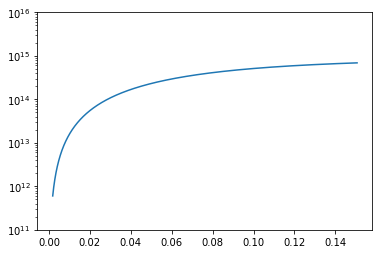

In [58]:
dislocation_density = [((k1/k2)**2) * ((1-np.exp((-k2*pl)/2))**2) for pl in true_plastic_strain]
_ = plt.plot(true_plastic_strain, dislocation_density)
_ = plt.yscale('log')
_ = plt.ylim(1e11, 1e16)
_ = plt.xlabel('$\epsilon_{pl}$')
_ = plt.ylabel('$\\theta$')

## Verifying value of $ \rho_{s} $

$\rho_{s}$ can be calculated in 2 ways.

#### Kocks mecking model
$$ \frac{d\sigma}{d\epsilon} = k_{1}\sqrt \rho - k_{2}\rho $$

At saturation stress, $ \frac{d\sigma}{d\epsilon} = 0$

$$ k_{1}\sqrt \rho_{rs} = k_{2}\rho_{s} $$

$$ \rho_{s} = \left(\frac{k_{1}}{k_{2}}\right)^2 $$

#### Taylor equation
$$ \sigma = \alpha\mu bM \sqrt \rho  $$

$$ \rho_{s} = \left(\frac{\sigma_{s}}{\alpha\mu bM} \right)^2 $$

In [62]:
lhs = (k1/k2)**2
rhs = (sigma_s/(alpha*shear_modulus*burger_vector_mag*taylor_factor))**2

(lhs, rhs)

(880050498664943.8, 880050498664943.8)